# Watch Price Valuator

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (12, 6)
plt.rc('axes', titlesize=22) 
plt.rc('figure', titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

## Data

### Extract

In [2]:
sqlite_file_name = "../scraper/database.db"
sqlite_url = f"sqlite:///{sqlite_file_name}"

In [3]:
df_original = pd.read_sql_table('watch', sqlite_url)

In [4]:
df = df_original

### Transform

In [5]:
df.columns

Index(['id', 'product_url', 'brand', 'series', 'model_num', 'model_id',
       'price', 'year', 'box', 'papers', 'image_url', 'image_filename'],
      dtype='object')

In [6]:
df.drop(['id', 'product_url', 'image_url', 'image_filename'], axis=1, inplace=True)

In [7]:
df.shape

(4299, 8)

In [8]:
df.head()

,brand,series,model_num,model_id,price,year,box,papers
0,Rolex,Datejust,116244,16793,10500,2014,True,True
1,Omega,Speedmaster MKII,327.10.43.50.06.001,24680,3560,2018,True,True
2,Cartier,Tank Francaise,W51008Q3,304,2450,2007,True,False
3,Tag Heuer,Carrera,CAR2A1Z.FT6044,29627,3470,2019,True,True
4,Rolex,Submariner,124060,48245,12100,2020,True,True


In [9]:
X, y = df.drop('price', axis=1), df['price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)

### Inspect

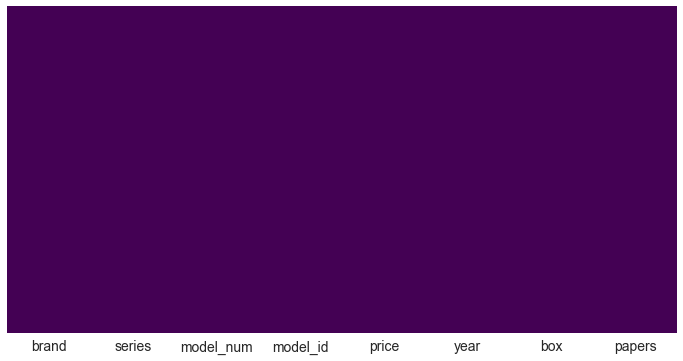

In [11]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

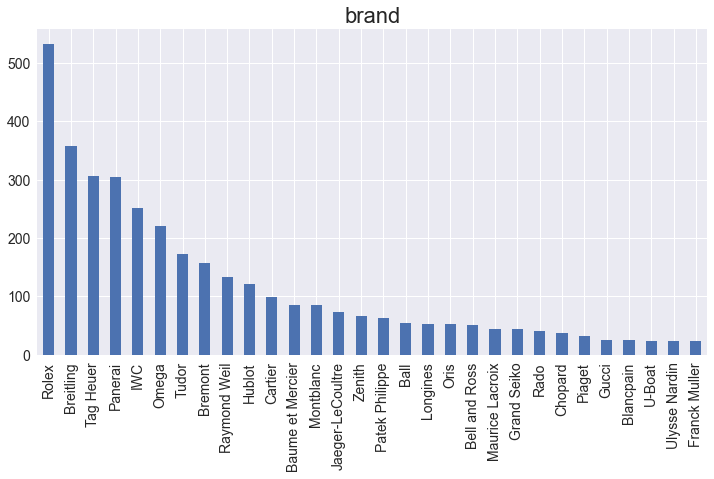

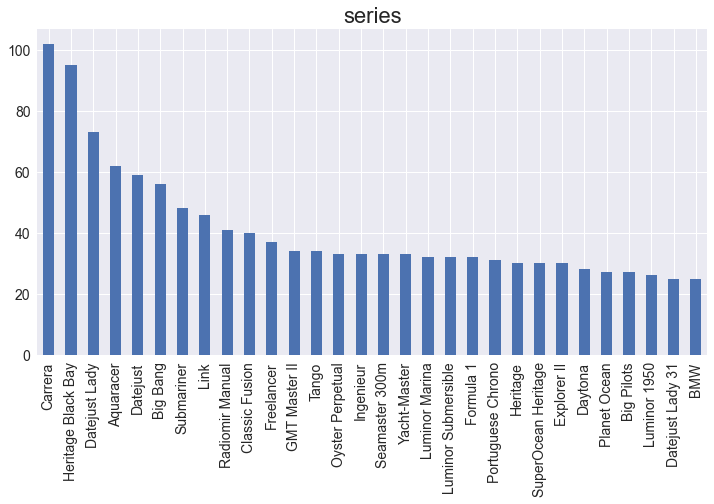

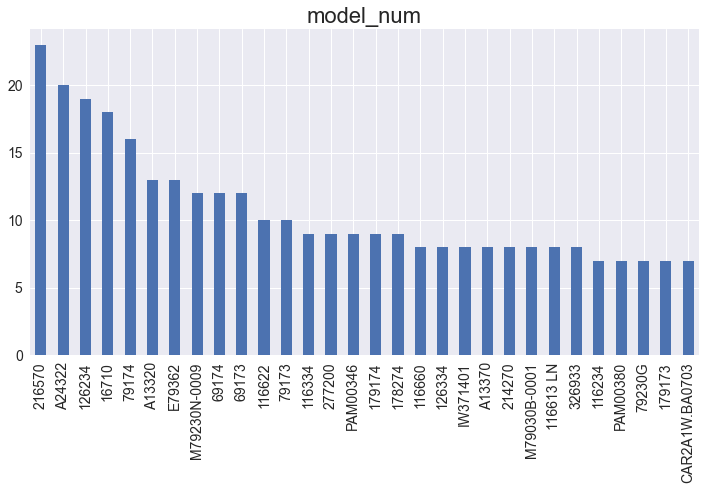

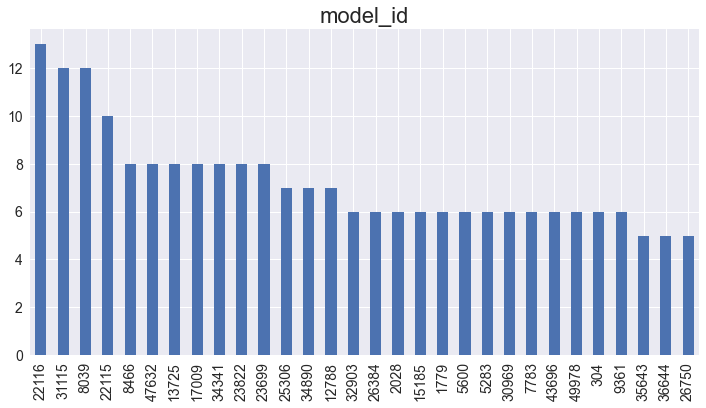

In [12]:
for col in ['brand', 'series', 'model_num', 'model_id']:
    X_train[col].value_counts()[:30].plot(kind='bar')
    plt.title(col)
    plt.show()

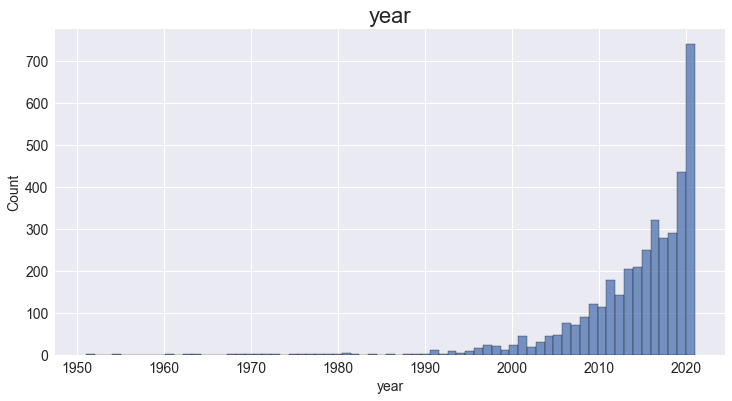

In [13]:
sns.histplot(data=X_train, x='year')
plt.title('year')
plt.show()

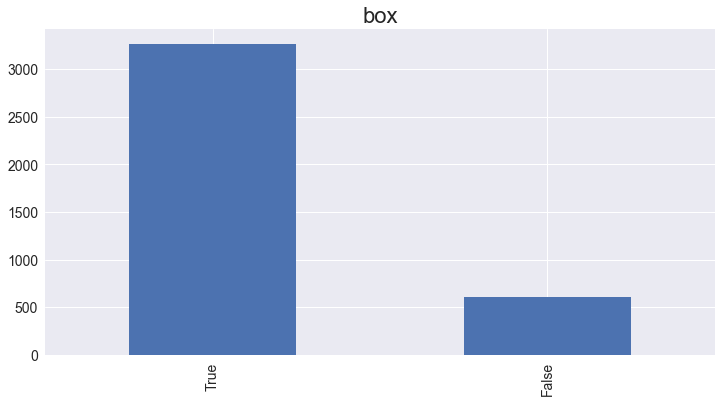

In [14]:
X_train['box'].value_counts().plot(kind='bar')
plt.title('box')
plt.show()

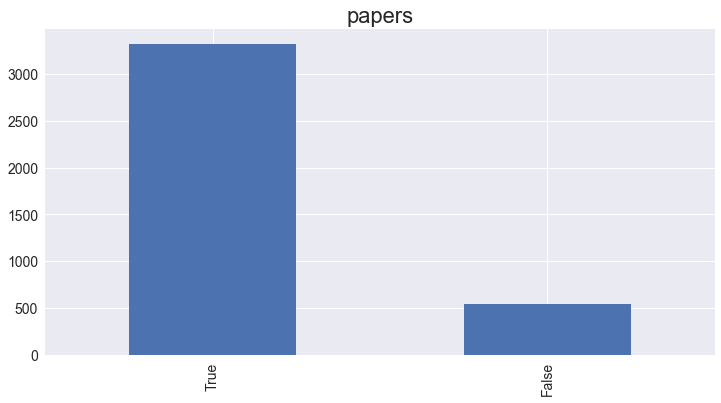

In [15]:
X_train['papers'].value_counts().plot(kind='bar')
plt.title('papers')
plt.show()

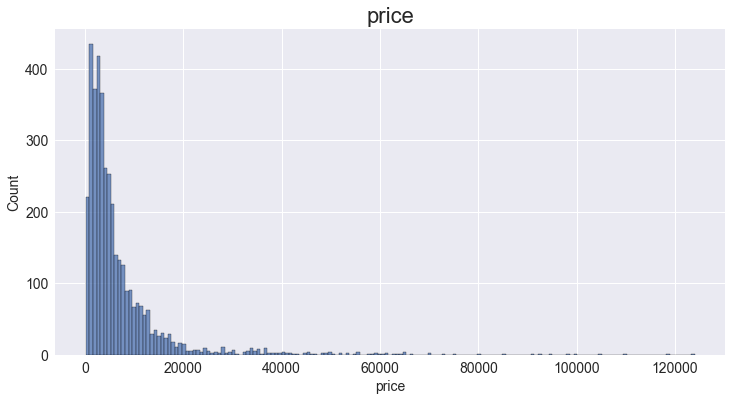

In [16]:
sns.histplot(y_train)
plt.title('price')
plt.show()

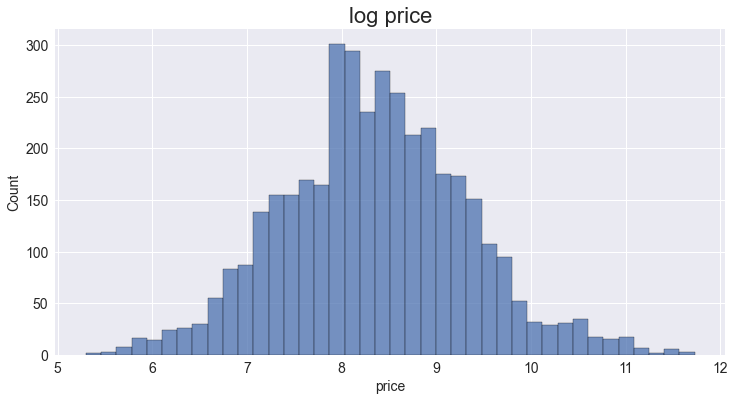

In [17]:
sns.histplot(np.log(y_train))
plt.title('log price')
plt.show()

### Feature Encoding

In [18]:
X_train_ = X_train.copy()

In [19]:
X_train_['box'] = X_train_['box'].map({True: 1, False: 0})

In [20]:
X_train_['papers'] = X_train_['papers'].map({True: 1, False: 0})

In [21]:
X_train_.head()

,brand,series,model_num,model_id,year,box,papers
3916,Tag Heuer,Carrera,CBN2A1F.BA0643,50293,2021,1,1
1041,IWC,Pilots Chrono Antoine de St Exupéry,IW377713,35882,2017,1,1
1322,Grand Seiko,Spring Drive,SBGE015,39189,2016,1,1
2260,Tag Heuer,Carrera,CV2A81.FC6237,28763,2019,1,1
1769,Breitling,Avenger II Seawolf,A17331,24707,2017,0,1


In [22]:
one_hot = OneHotEncoder()

In [23]:
one_hot.fit_transform(X_train).toarray()

array([[0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.]])

### Model Selection

### Feature Engineering

## Modelling